***
    
Demo JAX for PINN (Physics-Informed Neural Network)
    
***

    Version: 2023-02-24
    
    Author : Nicholas Sung Wei Yong, Wong Jian Cheng, Ooi Chin Chun, Abhishek Gupta

    Contain:
    
    1. PINN for solving projectile motion equation
    
    2. Optimize PINN using Stochastic gradient descent on the JAX framework
       -  as described in Nicholas Sung Wei Yong, Jian Cheng Wong, Pao-Hsiung Chiu, Abhishek Gupta, Chinchun Ooi, Yew-Soon Ong
       "Neuroevolution Surpasses Stochastic Gradient Descent for Physics-Informed Neural Networks" arXiv preprint arXiv:2212.07624 (2022).

Import Libraries

In [1]:
import jax
import optax
import time
import matplotlib.pyplot as plt
from typing import Any, Callable, Sequence, Optional
from jax import lax, random, numpy as jnp
import flax
import numpy as np
from flax.core import freeze, unfreeze
from flax import linen as nn
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax.config import config
from scipy import array, power, diag, pi
# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

PINNs Network

In [2]:
n_nodes = 8

class PINNs(nn.Module):
  """PINNs"""
  def setup(self):
    # hidden layers
    self.layers = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform(), use_bias=False),
                   nn.tanh,
                   nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh]
    # split layers
    self.splitx = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(1, use_bias=False)]
    self.splity = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(1, use_bias=False)]


  @nn.compact
  def __call__(self, inputs):
      # split the two variables, probably just by slicing
      t= inputs#[:,0:1]
      
      def get_xy(t):
        for i, lyr in enumerate(self.layers):
          t = lyr(t)
        # split layers
        hidden_x = self.splitx[0](t)
        hidden_x = self.splitx[1](hidden_x)
        hidden_y = self.splity[0](t)
        hidden_y = self.splity[1](hidden_y)
        # output layers
        x = self.splitx[2](hidden_x)
        y = self.splity[2](hidden_y)
        return x, y

      x, y = get_xy(t)

      # deriviatives needed to obtain are x_t, y_t, x_tt, y_tt
      def get_xy_t(get_xy, t):
        x_t, y_t = jacfwd(get_xy)(t)
        return x_t, y_t
      xy_t_vmap = vmap(get_xy_t, in_axes=(None, 0))
      x_t, y_t = xy_t_vmap(get_xy, t)
      x_t = x_t.reshape(-1,1)
      y_t = y_t.reshape(-1,1)
      def get_xy_tt(get_xy, t):
        x_tt, y_tt = hessian(get_xy)(t)
        return x_tt, y_tt
      xy_tt_vmap = vmap(get_xy_tt, in_axes=(None, 0))
      x_tt, y_tt = xy_tt_vmap(get_xy, t)
      x_tt = x_tt.reshape(-1,1)
      y_tt = y_tt.reshape(-1,1)
      action = jnp.hstack([x, y, x_t, y_t, x_tt, y_tt])   
      return action


# initialize model
model = PINNs()    

In [3]:
# choose seed
seed = 0
key1, key2 = random.split(random.PRNGKey(seed))
a = random.normal(key1, [1,1]) # Dummy input
params = model.init(key2, a) # Initialization call

In [4]:
from evojax.util import get_params_format_fn
num_params, format_params_fn = get_params_format_fn(params)
num_params

240

Problem

In [5]:
# function to generate analytical solution
def f_x(t):
    return x0 + t*u0

def f_y(t):
    return y0 + t*v0 - 1./2*g*t**2

def f_t():
    return (vel0*sin(a0*pi/180) + sqrt((vel0*sin(a0*pi/180))**2 + 2*g*y0)) / g

# free fall
def terminal_vel():
    vinf = sqrt(2*m*g / (d*Cd*A))
    return vinf

def f_yfree(t, vinf):
    y_free = y0 - vinf**2/g*log(np.cosh(g*t/vinf))
    return y_free

Hyper parameters and data 

In [6]:
# specify planet to change g, d & a_T
# planet = {'earth': (9.8, 1.2, 2), 'mars': (3.7, 0, 4.5), 'moon': (1.6, 0, 10)}
planet = {'earth': (9.8, 0, 2), 'mars': (3.7, 0, 4.5), 'moon': (1.6, 0, 10)}
g, d, a_T = planet['earth']

# parameter related to flying ball (constant)
m = 0.6
r = 0.12
Cd = 0.54
A = pi*r**2

# initial condition @(x, y) position
x0, y0 = 0, 2
# initial condition @velocity
vel0 = 8.0     

# angle of projectile
a0 = 75

# initial velocity
u0 = vel0 * np.cos(a0*pi/180)
v0 = vel0 * np.sin(a0*pi/180)

# time domain: 0 - t_T
t_T = a_T    # let it fly..

t_fitness = 0

# PDE data
n_pde= 10000
n_ic= 1
t = jnp.linspace(0, t_T, n_pde).reshape(-1, 1)
data_pde = t
labels_pde_x = f_x(t)
labels_pde_y = f_y(t)

Loss Function

In [7]:
# loss function parameter
lmbda = 1 #500

In [8]:
def loss(params, input):
    t = input[:,0:1]
    prediction = model.apply(format_params_fn(params), t)
    x, y, x_t, y_t, x_tt, y_tt = prediction[:,0:1], prediction[:,1:2], prediction[:,2:3], prediction[:,3:4], prediction[:,4:5], prediction[:,5:6]


    # ground truth
    x_true = f_x(t)
    y_true = f_y(t)  
    _ic = jnp.where((jnp.equal(t, 0)), 1, 0)

    # initial conditions (which define the problem)
    ic_1 = jnp.sum(jnp.square((x_true-x)*_ic))/jnp.sum(_ic)
    ic_2 = jnp.sum(jnp.square((y_true-y)*_ic))/jnp.sum(_ic)

    ic_3 = jnp.sum(jnp.square((x_t-u0)*_ic))/jnp.sum(_ic)
    ic_4 = jnp.sum(jnp.square((y_t-v0)*_ic))/jnp.sum(_ic)

    # sum up all initial conditions
    ic_mse = ic_1 + ic_2 + ic_3 + ic_4

    # consider drag effect
    V = jnp.sqrt( (x_t)**2 + (y_t)**2 )
    C = 0.5*d*Cd*A/m
    R = C*V

    # PDE (physics laws):
    pde_x = x_tt + R*x_t
    pde_y = y_tt + R*y_t + g
    # exclude BC points
    _pde = jnp.where((jnp.equal(t, 0)), 0, 1)
    pde_x = pde_x*_pde
    pde_y = pde_y*_pde        
    pde_residuals_x = jnp.sum(jnp.square(pde_x))/jnp.sum(_pde)
    pde_residuals_y = jnp.sum(jnp.square(pde_y))/jnp.sum(_pde)
    pde_mse = pde_residuals_x + pde_residuals_y

    loss = pde_mse + ic_mse
    return loss
  
#loss_grad = jax.jit(jax.grad(loss))
loss_grad = jax.jit(jax.value_and_grad(loss))    

Weights Update

In [9]:
def update(params, opt_state, batch_data):
    loss_value, grad = loss_grad(params, batch_data)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

update = jit(update)

Initialization

In [10]:
# initial params
params = model.init(key2, a) # Initialization call

# flatten initial params
params = jax.flatten_util.ravel_pytree(params)[0]

Optimizer

In [11]:
alpha = 0.001
#optimizer = optax.adam(learning_rate=alpha) # Choose the method
optimizer = optax.sgd(learning_rate=alpha) # Choose the method
opt_state = optimizer.init(params)

Minibatching

In [12]:
BS_pde = 1000

data_bc = data_pde[(0),:]
def minibatch(train_iters):
    _batch = jax.random.choice(random.PRNGKey(train_iters), n_pde, (BS_pde,))
    batch_data = jnp.vstack([data_pde[_batch], data_bc])
    return batch_data

minibatch = jit(minibatch)

Training 

In [13]:
max_iters = 500000
loss_ls = []
t_training = []
runtime = 0
train_iters = 0
while (train_iters < max_iters) and (runtime < 60):
    start = time.time()
    # stochastic update
    batch_data = minibatch(train_iters)
#     batch_data = data_pde
    params, opt_state, loss_value = update(params, opt_state, batch_data)
    end = time.time()
    t_training.append(end-start)
    loss_ls.append(loss_value)
    runtime += (end-start)
    train_iters += 1    
    # append weights
    show_iters = [1000, 5000, 10000, 50000, 100000]
    if (train_iters in show_iters):
        print('Loss step {}: '.format(train_iters), loss_value)
              
# final train_iters
train_iters

Loss step 1000:  33.549896
Loss step 5000:  2.1124287
Loss step 10000:  0.23632656
Loss step 50000:  0.0067317896
Loss step 100000:  0.0021941366


153587

In [14]:
# process results
import numpy as np
import pandas as pd

In [15]:
training_ls = np.cumsum(t_training)
training_ls

array([ 1.65623975,  1.65684605,  1.65727806, ..., 59.99941754,
       59.99980283, 60.00019908])

In [16]:
loss_ls[-1]

DeviceArray(0.00106912, dtype=float32)

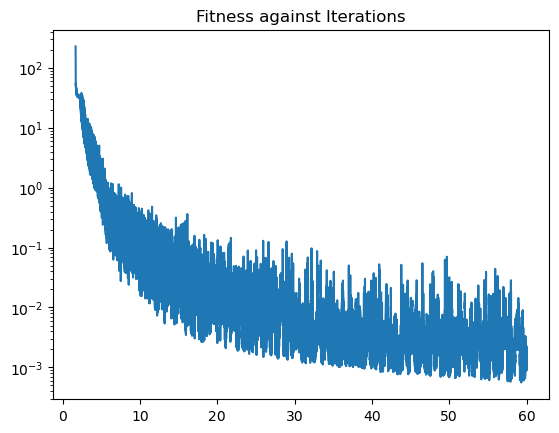

In [17]:
plt.plot(training_ls, loss_ls); plt.yscale('log');
plt.title('Fitness against Iterations')
plt.show()

#### Visualize results

Text(0.5, 1.0, 'y against t')

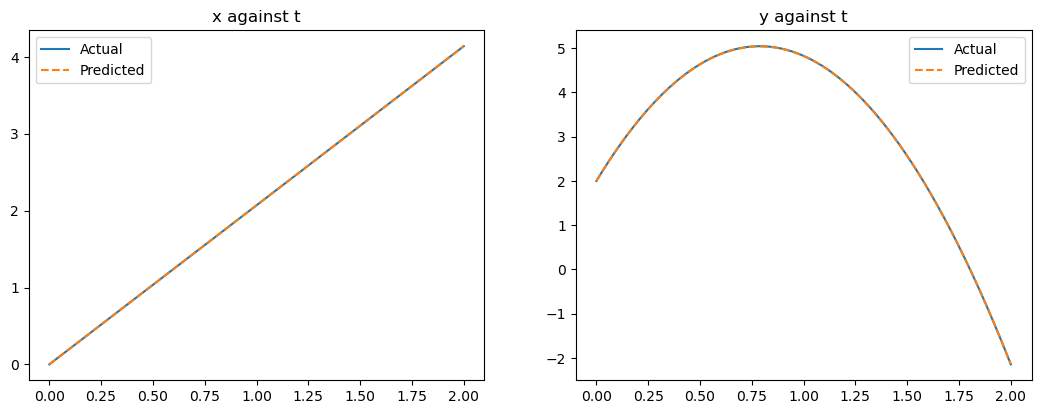

In [18]:
# plot final
hello = PINNs()
prediction = hello.apply(format_params_fn(params), data_pde)
prediction_x, prediction_y = prediction[:,0:1], prediction[:,1:2]
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(2,3,1)
plt.plot(t, labels_pde_x, label = "Actual")
plt.plot(t, prediction_x, '--', label = "Predicted")
plt.legend()
plt.title('x against t')
ax2 = fig.add_subplot(2,3,2)
plt.plot(t, labels_pde_y, label = "Actual")
plt.plot(t, prediction_y, '--', label = "Predicted")
plt.legend()
plt.title('y against t')

In [19]:
jnp.mean(jnp.square(labels_pde_x - prediction_x))

DeviceArray(1.8633577e-07, dtype=float32)

In [20]:
jnp.mean(jnp.square(labels_pde_y - prediction_y))

DeviceArray(1.2554548e-05, dtype=float32)